In [9]:
# Include sslearn folder
import sys
sys.path.append('../../../sslearn')
from sslearn.wrapper import CoTraining
from sslearn.base import OneVsRestSSLClassifier
import pickle as pkl
import numpy as np
import os
from SequenceEncoding import SequenceEncoding
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr, weightedtau
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from itertools import combinations, permutations

In [10]:
# results_dir = "results/multiview_experiments_BRCA1_HUMAN_Fields2015_e3_LinearRegression"
results_dir = "results/multiview_experiments_avgfp_Ridge"

In [13]:
encodings = ["One_hot", "One_hot_6_bit", "Binary_5_bit", "Hydrophobicity_matrix",
             "Meiler_parameters", "Acthely_factors", "PAM250", "BLOSUM62",
             "Miyazawa_energies", "Micheletti_potentials", "AESNN3",
             "ANN4D", "ProtVec"]
# Get list of tuples from combinations
labeled_sizes = [0.5, 0.25, 0.15, 0.1, 0.05, 0.03, 0.01]

comb = list(combinations(encodings, 2))

In [16]:
global_pred_dict = dict()

for enc1, enc2 in comb:
    global_pred_dict[enc1] = dict()
    global_pred_dict[enc2] = dict()
    global_pred_dict["concat-"+enc1+"-"+enc2] = dict()
    global_pred_dict["concat-"+enc2+"-"+enc1] = dict()
    global_pred_dict["st-lr-"+enc1+"-"+enc2] = dict()
    global_pred_dict["st-lr-"+enc2+"-"+enc1] = dict()
    global_pred_dict["st-mean-"+enc1+"-"+enc2] = dict()
    global_pred_dict["st-mean-"+enc2+"-"+enc1] = dict()

    for labeled_size in labeled_sizes:
        with open(f'{results_dir}/pred_dict_{enc1}_{labeled_size}.pickle', 'rb') as f:
            global_pred_dict[enc1][labeled_size] = pkl.load(f)
        with open(f'{results_dir}/pred_dict_{enc2}_{labeled_size}.pickle', 'rb') as f:
            global_pred_dict[enc2][labeled_size] = pkl.load(f)
        with open(f'{results_dir}/pred_dict_concat_{enc1}_{enc2}_{labeled_size}.pickle', 'rb') as f:
            data = pkl.load(f)
            global_pred_dict["concat-"+enc1+"-"+enc2][labeled_size] = data
            global_pred_dict["concat-"+enc2+"-"+enc1][labeled_size] = data
        with open(f'{results_dir}/pred_dict_st_lr_{enc1}_{enc2}_{labeled_size}.pickle', 'rb') as f:
            data = pkl.load(f)
            global_pred_dict["st-lr-"+enc1+"-"+enc2][labeled_size] = data
            global_pred_dict["st-lr-"+enc2+"-"+enc1][labeled_size] = data
        with open(f'{results_dir}/pred_dict_st_mean_{enc1}_{enc2}_{labeled_size}.pickle', 'rb') as f:
            data = pkl.load(f)
            global_pred_dict["st-mean-"+enc1+"-"+enc2][labeled_size] = data
            global_pred_dict["st-mean-"+enc2+"-"+enc1][labeled_size] = data

# Create results dataframe
df = pd.DataFrame(columns=['Labeled', 'Train_size', 'View', 'AUC'])
for view, labeled_sizes in global_pred_dict.items():
    for labeled_size, preds_list in labeled_sizes.items():
        for preds in preds_list:
            y_proba = preds["y_proba"]
            original_y_test = preds["original_y_test"]
            y_test = preds["y_test"]
            train_size = preds["train_len"]
            mse = mean_squared_error(y_test, y_proba)
            spearman_r = spearmanr(original_y_test, y_proba)[0]
            weighted_tau = weightedtau(original_y_test, y_proba)[0]
            df = pd.concat([df, pd.DataFrame({'Labeled': labeled_size, 
                                              'Train_size': train_size, 
                                              'View': view, 
                                              'MSE': mse, 
                                              'Spearman_r': spearman_r,
                                              'Weighted_tau': weighted_tau
                                              }, index=[0])], ignore_index=True)

In [11]:
def get_one_vs_all_results(df, metric, encodings, view, views):
    # Read times best from pkl for each results folder (each pair of encodings)
    one_vs_all_dict = dict()

    # Shape of the dictionary pickled is:
    # cotraining_vs_best_dict -> labeled_percentage -> k -> difference from cotraining auc to best

    # Getting mean results from kfold
    comb = permutations(encodings, 2)
    for enc1, enc2 in comb:
        one_vs_all_dict[(enc1, enc2)] = dict()
        for labeled_percentage in df['Labeled'].unique():
            means = dict()
            means["View1"] = df.loc[(df['Labeled'] == labeled_percentage) & (df['View'] == enc1)][metric].mean()
            means["View2"] = df.loc[(df['Labeled'] == labeled_percentage) & (df['View'] == enc2)][metric].mean()
            means["Concat"] = df.loc[(df['Labeled'] == labeled_percentage) & (df['View'] == f"concat-{enc1}-{enc2}")][metric].mean()
            means["Stacking-lr"] = df.loc[(df['Labeled'] == labeled_percentage) & (df['View'] == f"st-lr-{enc1}-{enc2}")][metric].mean()
            means["Stacking-mean"] = df.loc[(df['Labeled'] == labeled_percentage) & (df['View'] == f"st-mean-{enc1}-{enc2}")][metric].mean()

            # Get the difference between cotraining and best
            # Get the difference between means[view] and the maximum of the rest of the values of the dictionary
            one_vs_all_dict[(enc1, enc2)][labeled_percentage] = means[view] - max([means[rival] for rival in views if rival != view])
    return one_vs_all_dict

In [12]:
def get_individual_results(df, metric, encodings, view_combination, views):
    # Read times best from pkl for each results folder (each pair of encodings)
    individual_results_dict = dict()

    # Getting mean results from kfold
    for enc1, enc2 in permutations(encodings, 2):
        individual_results_dict[(enc1, enc2)] = dict()
        for labeled_percentage in df['Labeled'].unique():
            # Get a dictionary with the mean of k folds
            if view_combination == "CoTraining":
                individual_results_dict[(enc1, enc2)][labeled_percentage] = df.loc[(df['Labeled'] == labeled_percentage) & (df['View'] == f"cotraining-{enc1}-{enc2}")][metric].mean()
            elif view_combination == "View1":
                individual_results_dict[(enc1, enc2)][labeled_percentage] = df.loc[(df['Labeled'] == labeled_percentage) & (df['View'] == enc1)][metric].mean()
            elif view_combination == "View2":
                individual_results_dict[(enc1, enc2)][labeled_percentage] = df.loc[(df['Labeled'] == labeled_percentage) & (df['View'] == enc2)][metric].mean()
            elif view_combination == "Concat":
                individual_results_dict[(enc1, enc2)][labeled_percentage] = df.loc[(df['Labeled'] == labeled_percentage) & (df['View'] == f"concat-{enc1}-{enc2}")][metric].mean()
            elif view_combination == "Stacking-lr":
                individual_results_dict[(enc1, enc2)][labeled_percentage] = df.loc[(df['Labeled'] == labeled_percentage) & (df['View'] == f"st-lr-{enc1}-{enc2}")][metric].mean()
            elif view_combination == "Stacking-mean":
                individual_results_dict[(enc1, enc2)][labeled_percentage] = df.loc[(df['Labeled'] == labeled_percentage) & (df['View'] == f"st-mean-{enc1}-{enc2}")][metric].mean()
    return individual_results_dict

In [13]:
import pandas as pd

def create_heatmap_dict(one_vs_all_dict, labeled, view, plot=False):

    heatmap_dict = {}

    number_of_experiments = 0
    for encodings, results in one_vs_all_dict.items():
        enc1, enc2 = encodings
        
        heatmap_dict[(enc1, enc2)] = results[labeled]

    ser = pd.Series(list(heatmap_dict.values()),
                    index=pd.MultiIndex.from_tuples(heatmap_dict.keys()))
    df = ser.unstack().fillna(0)

    # Set new column and index order
    new_columns_order = ['One_hot', 'One_hot_6_bit', 'Binary_5_bit', # Binary
                        'Hydrophobicity_matrix', 'Meiler_parameters', 'Acthely_factors', # Physicochemical properties
                        'PAM250', 'BLOSUM62', # Evolution-based
                        'Miyazawa_energies', 'Micheletti_potentials', # Structure-based 
                        'AESNN3', 'ANN4D', 'ProtVec']   # Machine learning-based

    groups_dict = {"Binary": ['One_hot', 'One_hot_6_bit', 'Binary_5_bit'],
                    "Physicochemical": ['Hydrophobicity_matrix', 'Meiler_parameters', 'Acthely_factors'],
                    "Evolution": ['PAM250', 'BLOSUM62'],
                    "Structure": ['Miyazawa_energies', 'Micheletti_potentials'],
                    "Machine learning": ['AESNN3', 'ANN4D', 'ProtVec']}

    new_index_order = new_columns_order
    df = df.reindex(new_index_order, axis=0)
    df = df.reindex(new_columns_order, axis=1)
    # Fill nans with 0
    df = df.fillna(0)

    if plot:
        # Set heatmap limits to 1 and 0
        # Hide heatmap legend
        sns.heatmap(df, cmap="RdYlGn", center=0)#, vmin=-0.1, vmax=0.1)
        # Group heatmap columns by group
        for group, encodings in groups_dict.items():
            plt.axvline(x=new_columns_order.index(encodings[0]), color='black', linewidth=1)
            plt.axhline(y=new_columns_order.index(encodings[0]), color='black', linewidth=1)
            plt.text(x=-10, y=new_columns_order.index(encodings[-1])-1, s=group, rotation=0, fontsize=8)
            
        # Set title
        plt.title(f'{view} being best | {labeled*100}% labeled)', fontsize=14)
        plt.show()
    return df

In [26]:
from matplotlib.patches import Patch
# Plots the best value from every view combination and the color in the heatmap is the one corresponding to the best method
def create_heatmap_dict_best(individual_results_dict, labeled, metric, vmin=0, vmax=1, center=0.5):

    cmap1 = sns.light_palette("blue", as_cmap=True)
    cmap1.set_under('none')
    cmap2 = sns.light_palette("red", as_cmap=True)
    cmap2.set_under('none')
    cmap3 = sns.light_palette("yellow", as_cmap=True)
    cmap3.set_under('none')
    cmap4 = sns.light_palette("purple", as_cmap=True)
    cmap4.set_under('none')
    cmap5 = sns.light_palette("orange", as_cmap=True)
    cmap5.set_under('none')

    
    data1 = individual_results_dict["View1"]
    data2 = individual_results_dict["View2"]
    data3 = individual_results_dict["Concat"]
    data4 = individual_results_dict["Stacking-lr"]
    data5 = individual_results_dict["Stacking-mean"]

    # Combine dataframes data1, data2, data3, etc. getting the best value for each cell
    max_df = pd.concat([data1, data2, data3, data4, data5]).groupby(level=0).max()

    new_columns_order = ['One_hot', 'One_hot_6_bit', 'Binary_5_bit', # Binary
                        'Hydrophobicity_matrix', 'Meiler_parameters', 'Acthely_factors', # Physicochemical properties
                        'PAM250', 'BLOSUM62', # Evolution-based
                        'Miyazawa_energies', 'Micheletti_potentials', # Structure-based 
                        'AESNN3', 'ANN4D', 'ProtVec']   # Machine learning-based
    groups_dict = {"Binary": ['One_hot', 'One_hot_6_bit', 'Binary_5_bit'],
                  "Physicochemical": ['Hydrophobicity_matrix', 'Meiler_parameters', 'Acthely_factors'],
                  "Evolution": ['PAM250', 'BLOSUM62'],
                  "Structure": ['Miyazawa_energies', 'Micheletti_potentials'],
                  "Machine learning": ['AESNN3', 'ANN4D', 'ProtVec']}
    # Reorder columns and indexes
    max_df = max_df[new_columns_order]
    max_df = max_df.reindex(new_columns_order)

    # Change to 0 every value that is not the best value
    data1 = data1.where(data1 == max_df, 0)
    data2 = data2.where(data2 == max_df, 0)
    data3 = data3.where(data3 == max_df, 0)
    data4 = data4.where(data4 == max_df, 0)
    data5 = data5.where(data5 == max_df, 0)  

    # Fig size bigger
    plt.figure(figsize=(15, 5))
    if metric == 'AUC':
        vmin = 0.5
        vmax = 1
        center = 0.75
    
    ax1 = sns.heatmap(data1, vmin=0.0000001, vmax=vmax, cmap=cmap1, cbar_kws={'pad': -0.05}, center=center)
    sns.heatmap(data2, vmin=0.0000001, vmax=vmax, cmap=cmap2, cbar_kws={'pad': -0.04}, center=center)
    sns.heatmap(data3, vmin=0.0000001, vmax=vmax, cmap=cmap3, cbar_kws={'pad': -0.03}, center=center)
    sns.heatmap(data4, vmin=0.0000001, vmax=vmax, cmap=cmap4, cbar_kws={'pad': -0.02}, center=center)
    sns.heatmap(data5, vmin=0.0000001, vmax=vmax, cmap=cmap5, center=center)
    
    # Group heatmap columns by group
    for group, encodings in groups_dict.items():
        plt.axvline(x=new_columns_order.index(encodings[0]), color='black', linewidth=1)
        plt.axhline(y=new_columns_order.index(encodings[0]), color='black', linewidth=1)
        plt.text(x=-10, y=new_columns_order.index(encodings[-1])-1, s=group, rotation=0, fontsize=8)
    plt.title(f'Best view | {labeled*100}% labeled | {metric}', fontsize=14)

    # Legend with colors
    legend_elements = [Patch(facecolor=cmap1(1000), edgecolor='black', label='View1'),
                          Patch(facecolor=cmap2(1000), edgecolor='black', label='View2'),
                            Patch(facecolor=cmap3(1000), edgecolor='black', label='Concat'),
                            Patch(facecolor=cmap4(1000), edgecolor='black', label='Stacking-lr'),
                            Patch(facecolor=cmap5(1000), edgecolor='black', label='Stacking-mean')]
    plt.legend(handles=legend_elements, loc=(1, 50), bbox_to_anchor=(1.01, 1.01), fontsize=10)
       
    
    plt.show()

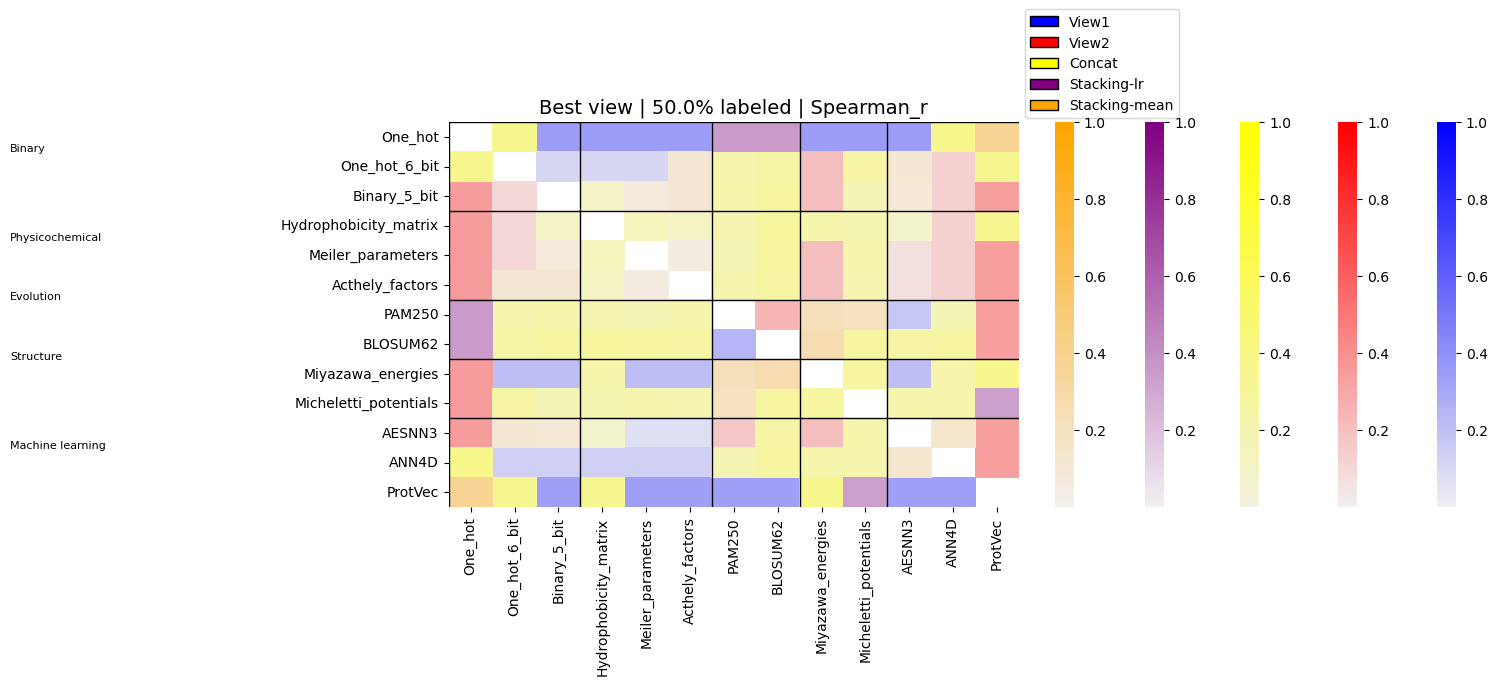

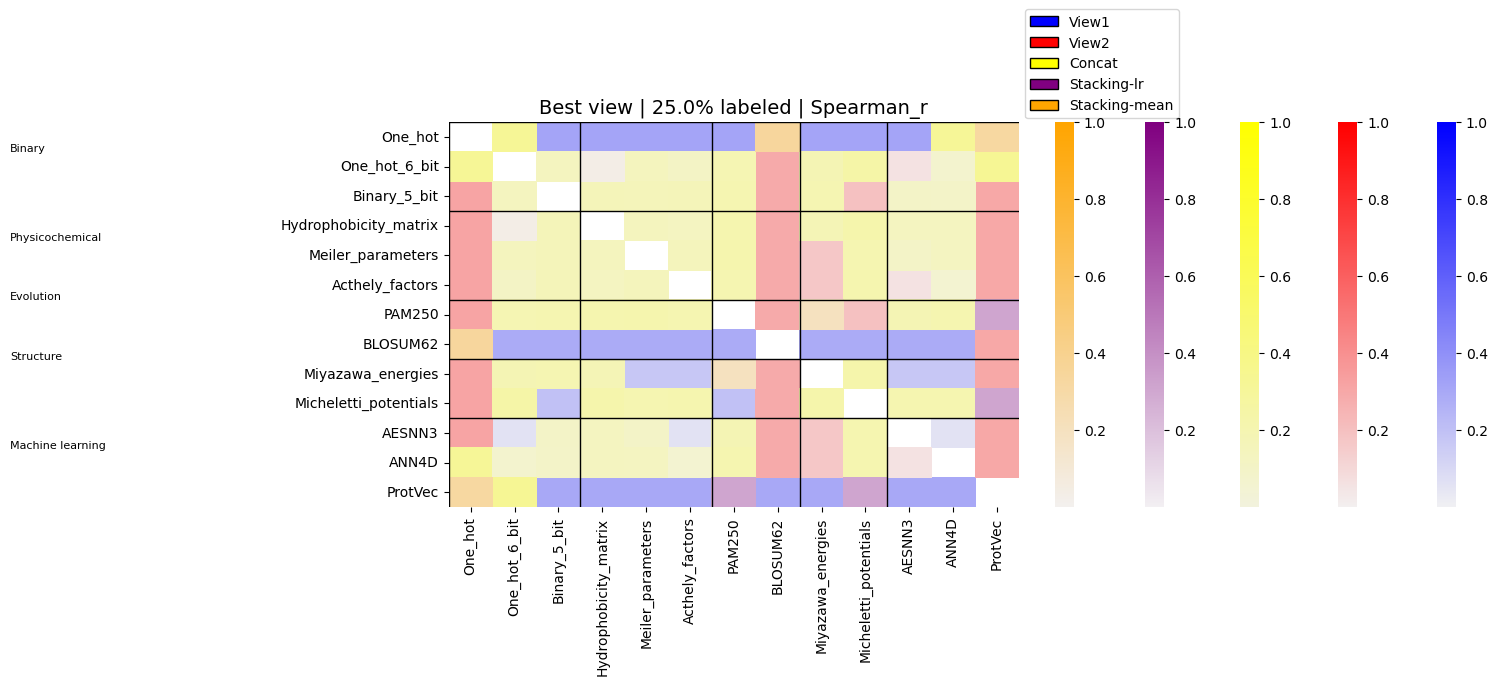

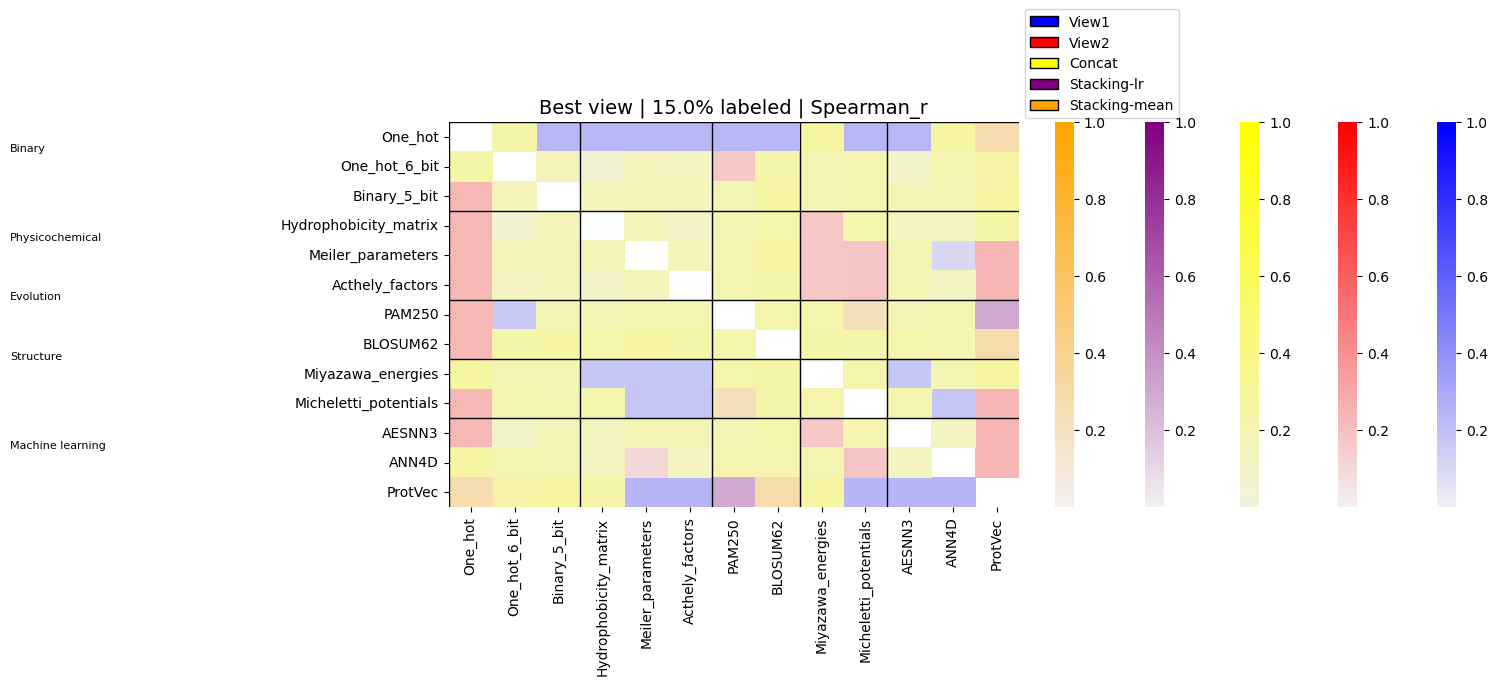

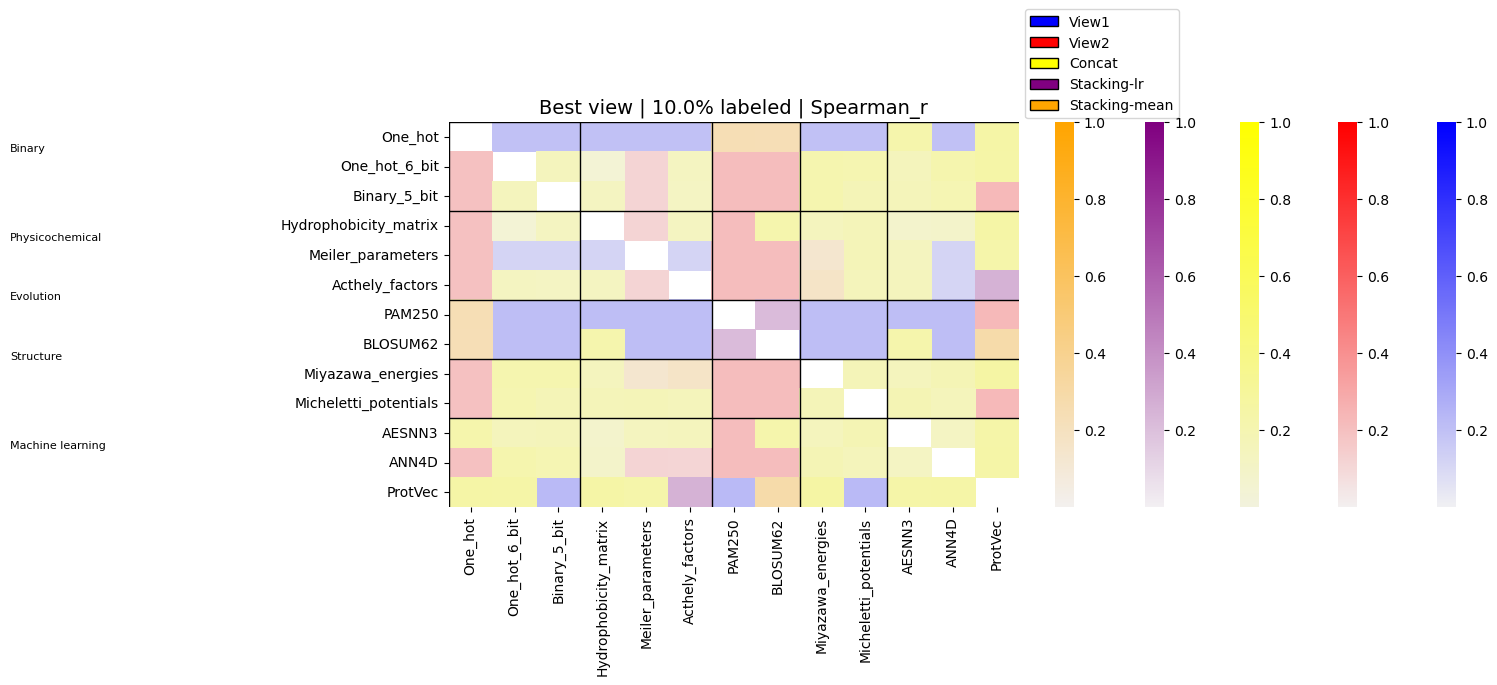

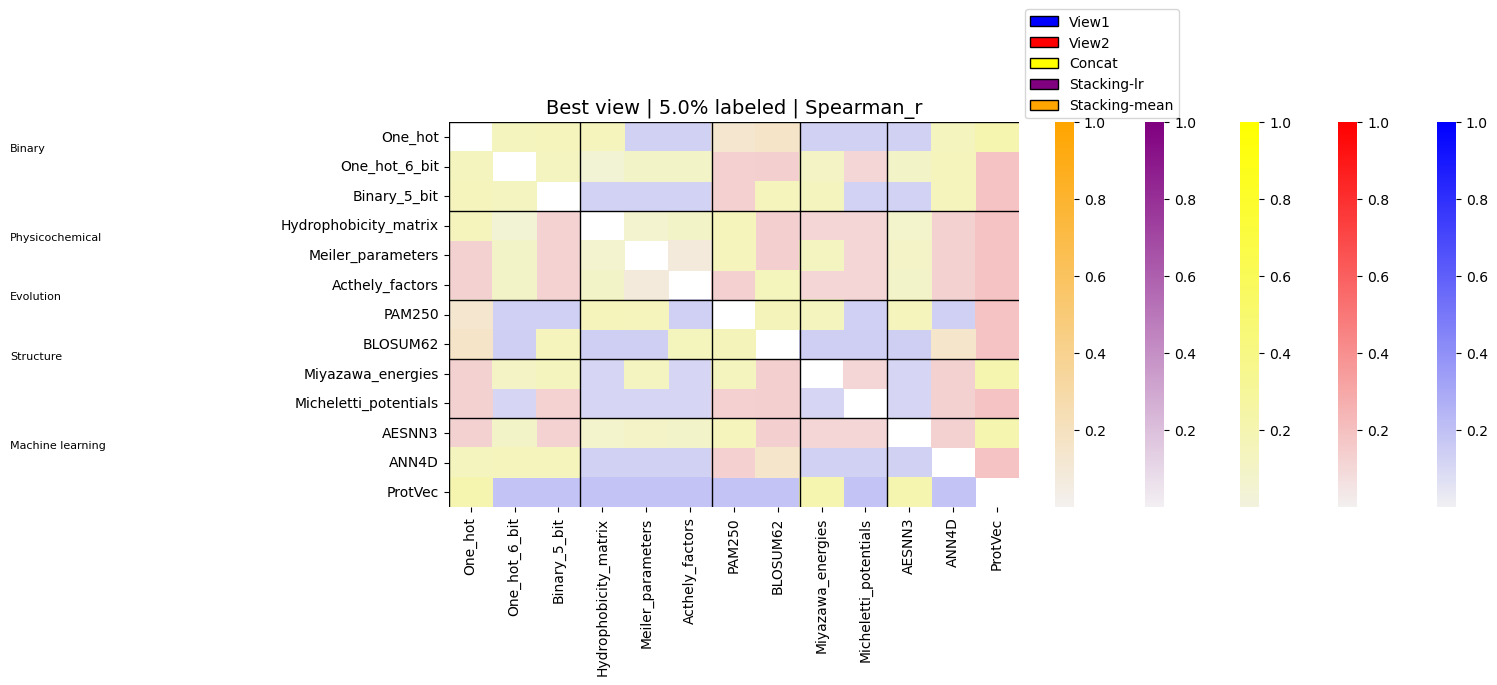

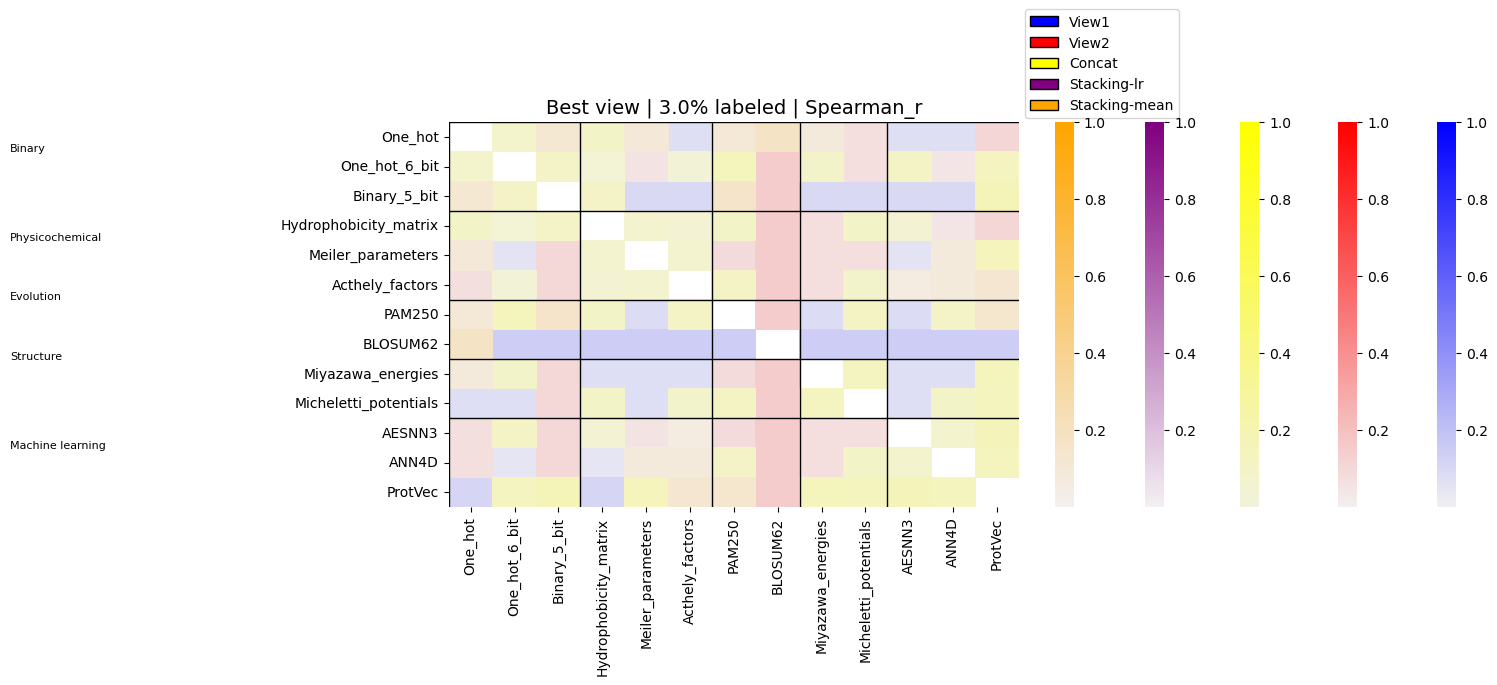

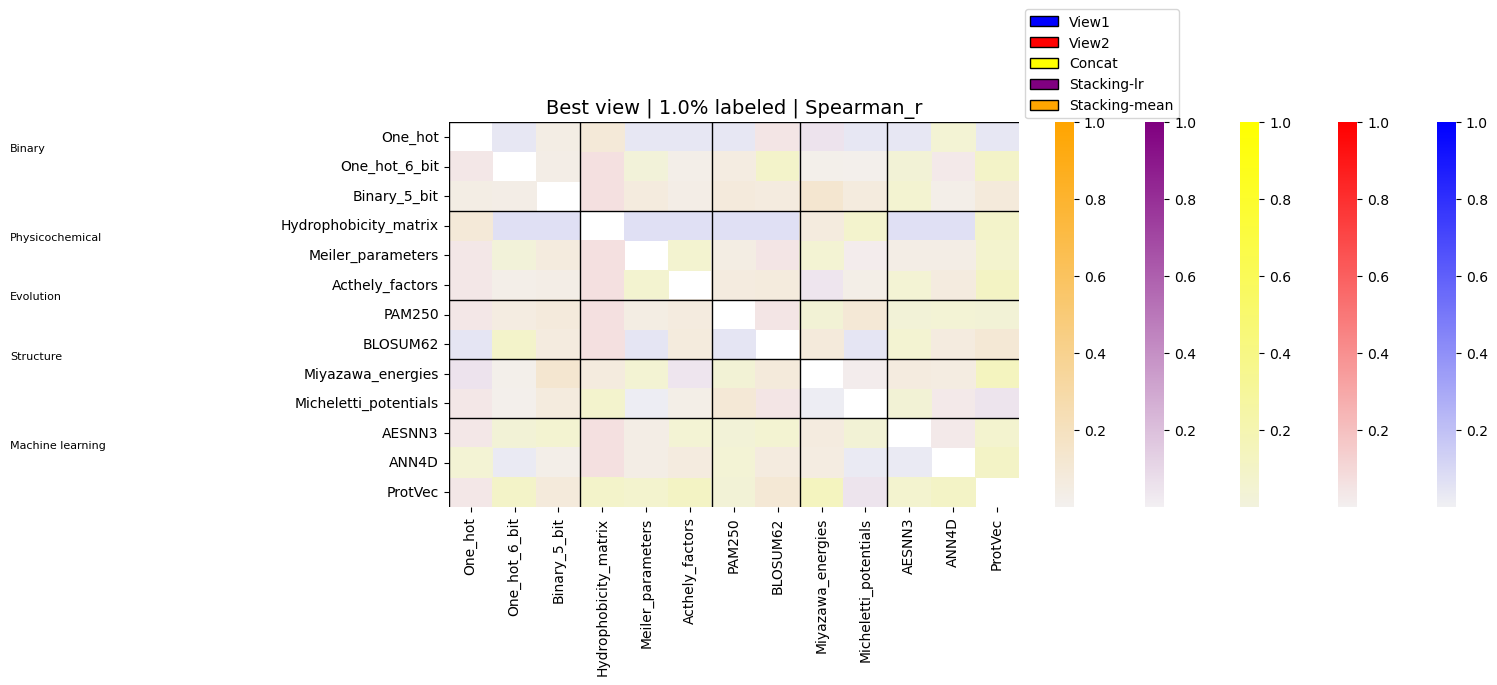

In [27]:
labeled_sizes =  [0.5, 0.25, 0.15, 0.1, 0.05, 0.03, 0.01]
# labeled_sizes =  [0.1]
for labeled_size in labeled_sizes:
    
    views =  ["CoTraining", "Concat", "Stacking-mean", "View1", "View2"]
    metric = "Spearman_r"   # "MSE", "Spearman_r" or "Spearman_tau"
    individual_results_dict = {}
    individual_results_dict["View1"] = create_heatmap_dict(get_individual_results(df, metric, encodings, "View1", views), labeled_size, "View1")
    individual_results_dict["View2"] = create_heatmap_dict(get_individual_results(df, metric, encodings, "View2", views), labeled_size, "View2")
    individual_results_dict["Concat"] = create_heatmap_dict(get_individual_results(df, metric, encodings, "Concat", views), labeled_size, "Concat")
    individual_results_dict["Stacking-lr"] = create_heatmap_dict(get_individual_results(df, metric, encodings, "Stacking-lr", views), labeled_size, "Stacking-lr")
    individual_results_dict["Stacking-mean"] = create_heatmap_dict(get_individual_results(df, metric, encodings, "Stacking-mean", views), labeled_size, "Stacking-mean")
   
    create_heatmap_dict_best(individual_results_dict, labeled_size, metric)


In [28]:
from matplotlib.patches import Patch
def create_heatmap_dict_all_vs_all(one_vs_all_dict, labeled, metric):
    cmap1 = sns.light_palette("blue", as_cmap=True)
    cmap1.set_under('none')
    cmap2 = sns.light_palette("red", as_cmap=True)
    cmap2.set_under('none')
    cmap3 = sns.light_palette("yellow", as_cmap=True)
    cmap3.set_under('none')
    cmap4 = sns.light_palette("purple", as_cmap=True)
    cmap4.set_under('none')
    cmap5 = sns.light_palette("orange", as_cmap=True)
    cmap5.set_under('none')

    
    data1 = one_vs_all_dict["View1"]
    data2 = one_vs_all_dict["View2"]
    data3 = one_vs_all_dict["Concat"]
    data4 = one_vs_all_dict["Stacking-lr"]
    data5 = one_vs_all_dict["Stacking-mean"]

    new_columns_order = ['One_hot', 'One_hot_6_bit', 'Binary_5_bit', # Binary
                        'Hydrophobicity_matrix', 'Meiler_parameters', 'Acthely_factors', # Physicochemical properties
                        'PAM250', 'BLOSUM62', # Evolution-based
                        'Miyazawa_energies', 'Micheletti_potentials', # Structure-based 
                        'AESNN3', 'ANN4D', 'ProtVec']   # Machine learning-based
    groups_dict = {"Binary": ['One_hot', 'One_hot_6_bit', 'Binary_5_bit'],
                  "Physicochemical": ['Hydrophobicity_matrix', 'Meiler_parameters', 'Acthely_factors'],
                  "Evolution": ['PAM250', 'BLOSUM62'],
                  "Structure": ['Miyazawa_energies', 'Micheletti_potentials'],
                  "Machine learning": ['AESNN3', 'ANN4D', 'ProtVec']}
    
    # Vmax to highest value of all heatmaps
    vmax = max(data1.max().max(), data2.max().max(), data3.max().max(), data4.max().max(), data5.max().max())

    # Fig size bigger
    plt.figure(figsize=(15, 5))
    
    ax1 = sns.heatmap(data1, vmin=0.0000001, vmax=vmax, cmap=cmap1, cbar_kws={'pad': -0.05})
    sns.heatmap(data2, vmin=0.0000001, vmax=vmax, cmap=cmap2, cbar_kws={'pad': -0.04})
    sns.heatmap(data3, vmin=0.0000001, vmax=vmax, cmap=cmap3, cbar_kws={'pad': -0.03})
    sns.heatmap(data4, vmin=0.0000001, vmax=vmax, cmap=cmap4, cbar_kws={'pad': -0.02})
    sns.heatmap(data5, vmin=0.0000001, vmax=vmax, cmap=cmap5)
    # Group heatmap columns by group
    for group, encodings in groups_dict.items():
        plt.axvline(x=new_columns_order.index(encodings[0]), color='black', linewidth=1)
        plt.axhline(y=new_columns_order.index(encodings[0]), color='black', linewidth=1)
        plt.text(x=-10, y=new_columns_order.index(encodings[-1])-1, s=group, rotation=0, fontsize=8)
    plt.title(f'Best view | {labeled*100}% labeled | {metric}', fontsize=14)

    # Legend with colors
    legend_elements = [ Patch(facecolor=cmap1(1000), edgecolor='black', label='View1'),
                        Patch(facecolor=cmap2(1000), edgecolor='black', label='View2'),
                        Patch(facecolor=cmap3(1000), edgecolor='black', label='Concat'),
                        Patch(facecolor=cmap4(1000), edgecolor='black', label='Stacking-lr'),
                        Patch(facecolor=cmap5(1000), edgecolor='black', label='Stacking-mean')]
    plt.legend(handles=legend_elements, loc=(1, 50), bbox_to_anchor=(1.01, 1.01), fontsize=10)
       
    
    plt.show()

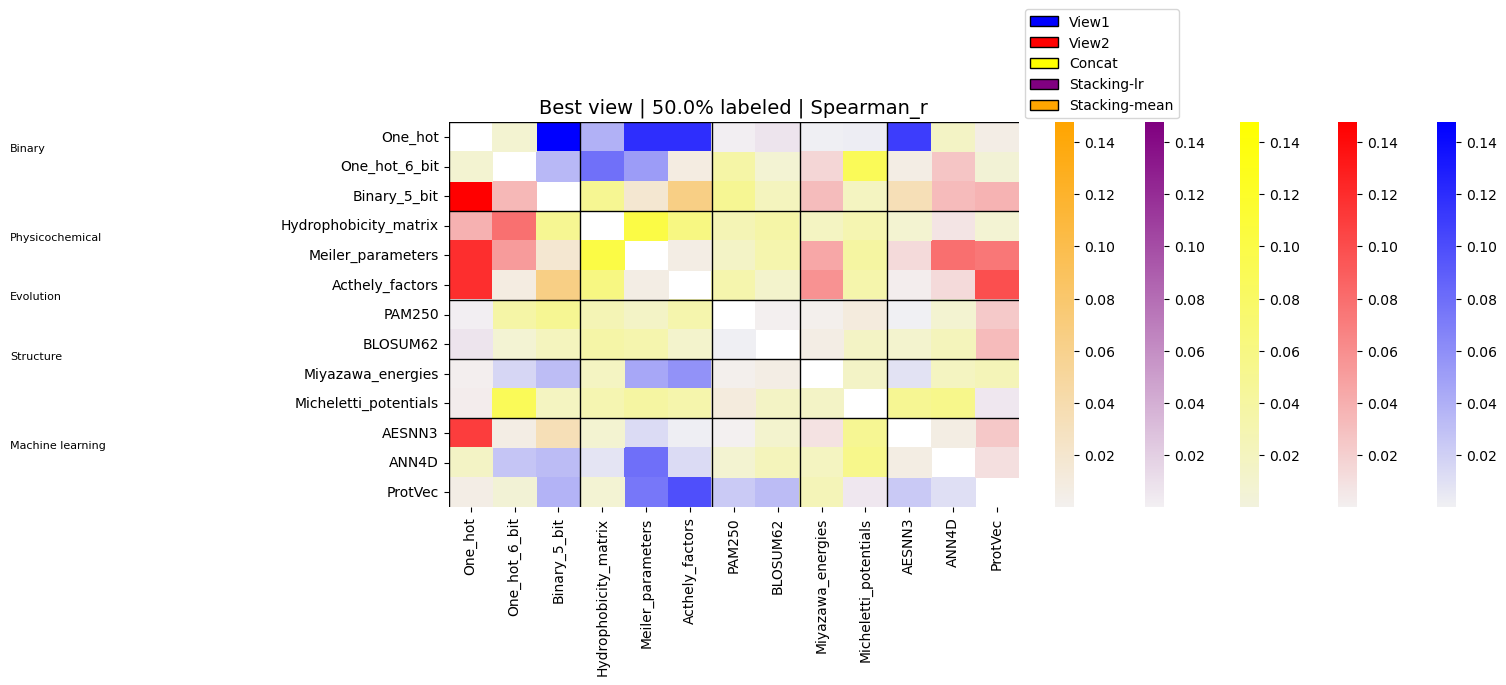

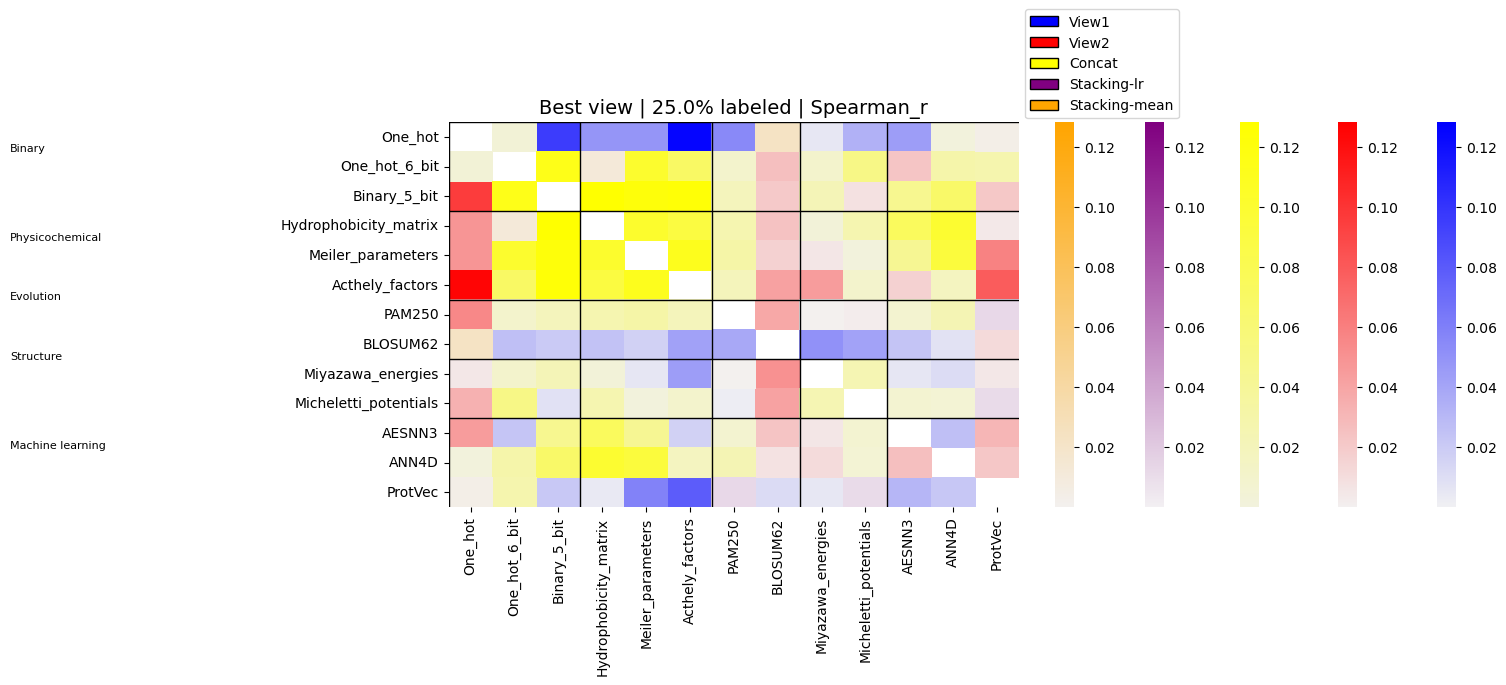

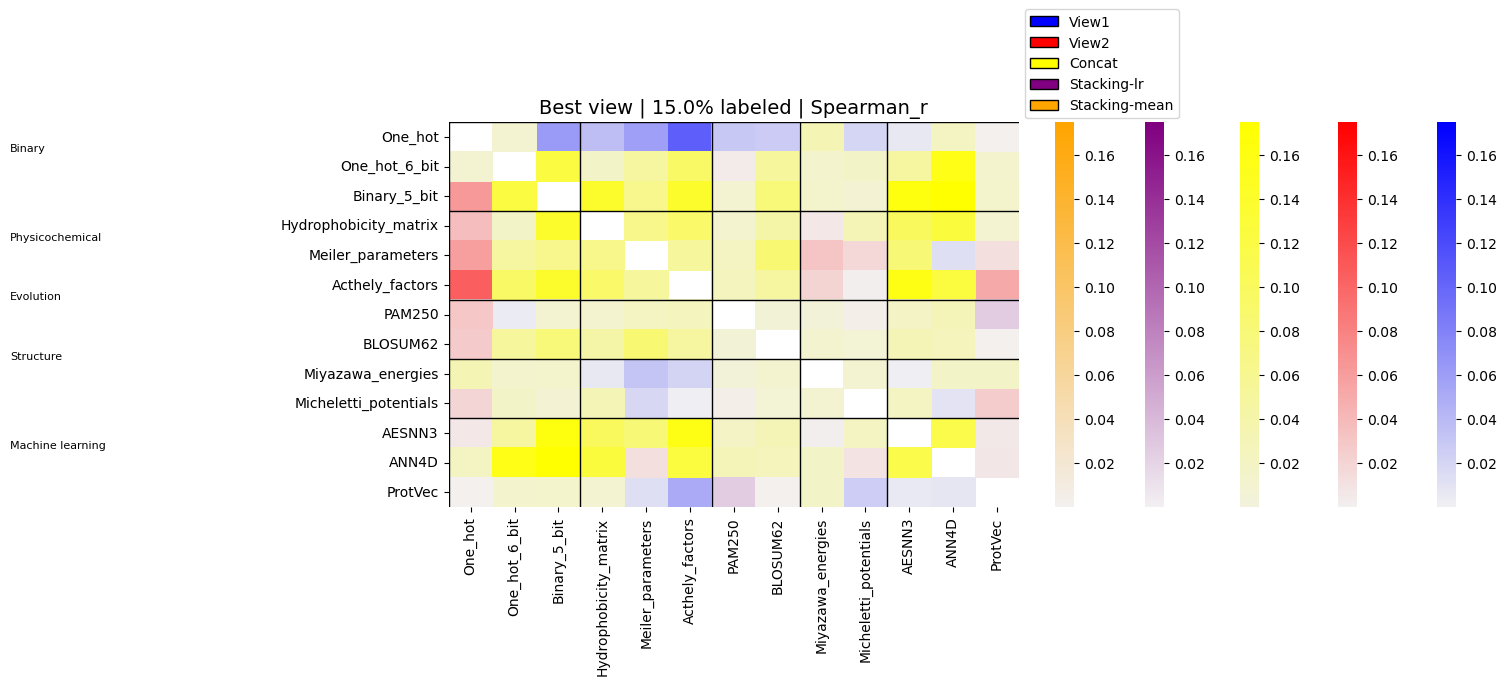

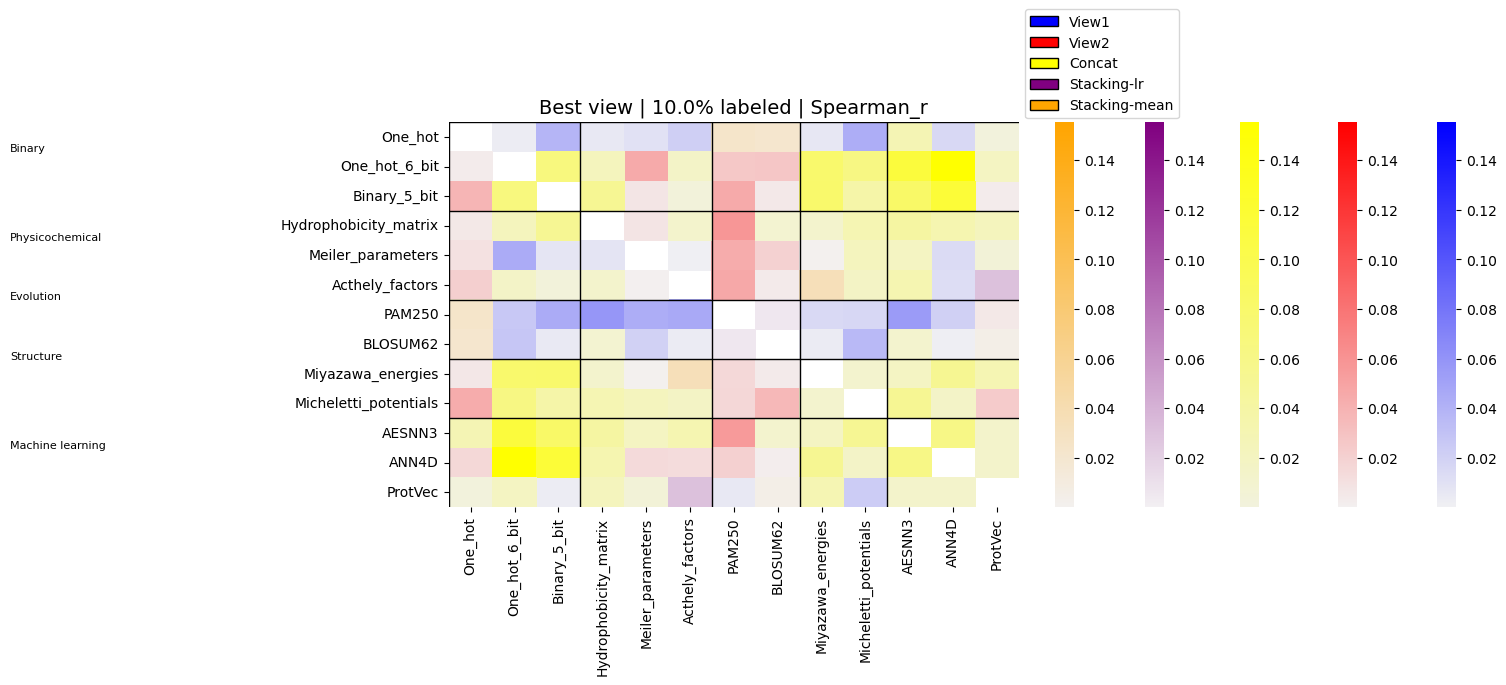

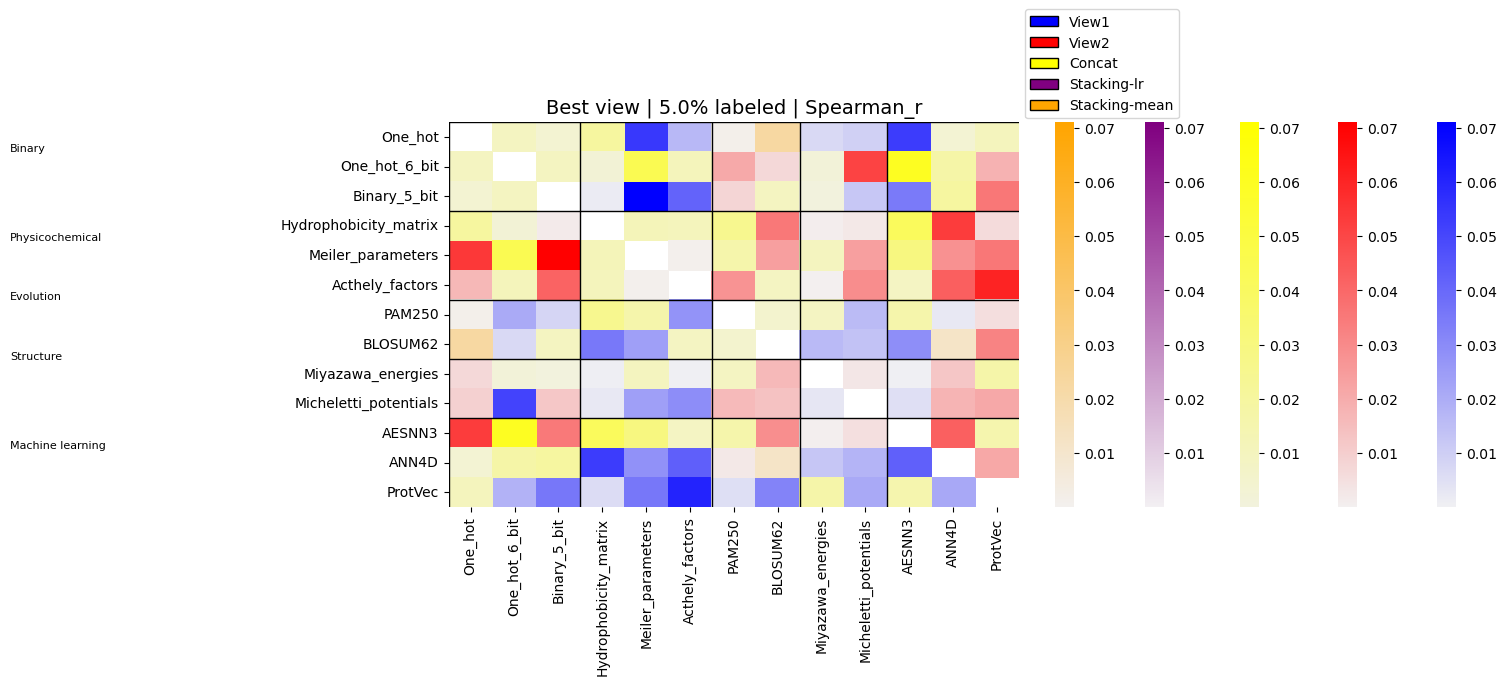

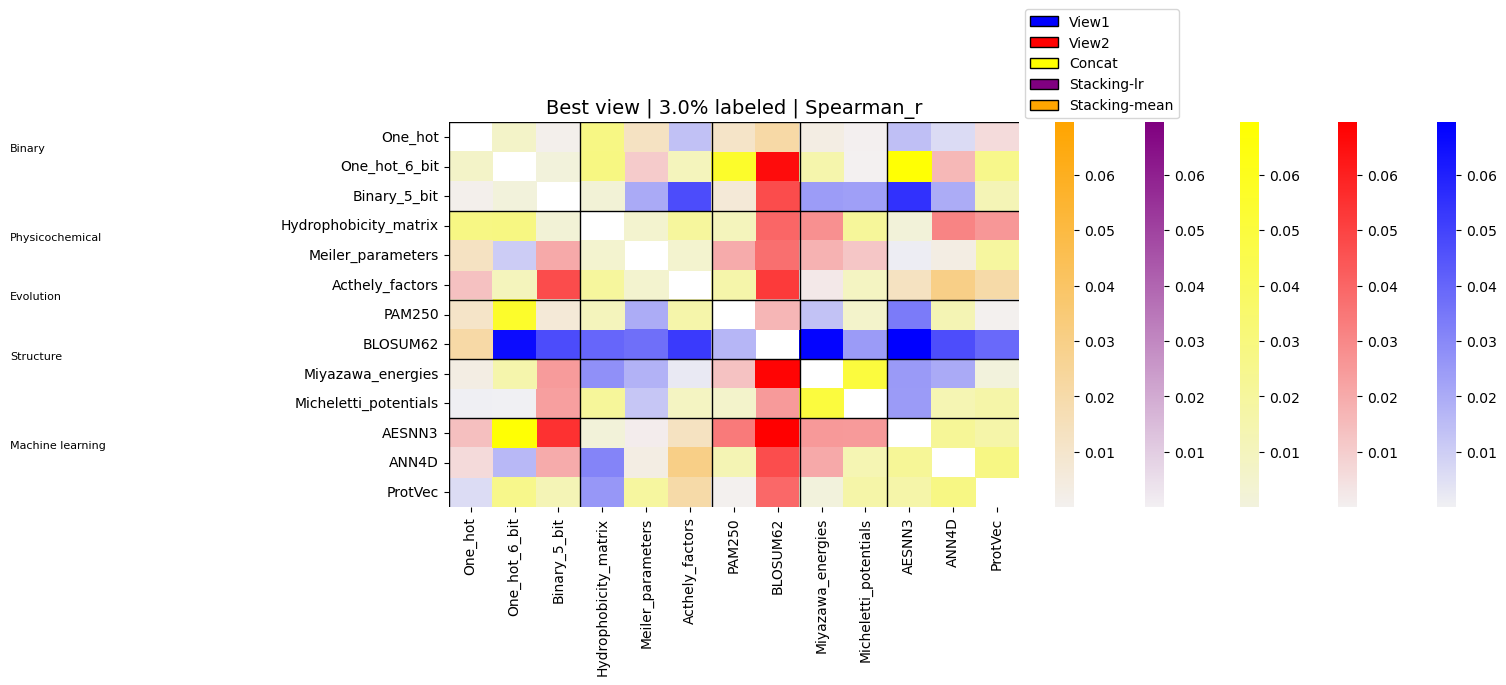

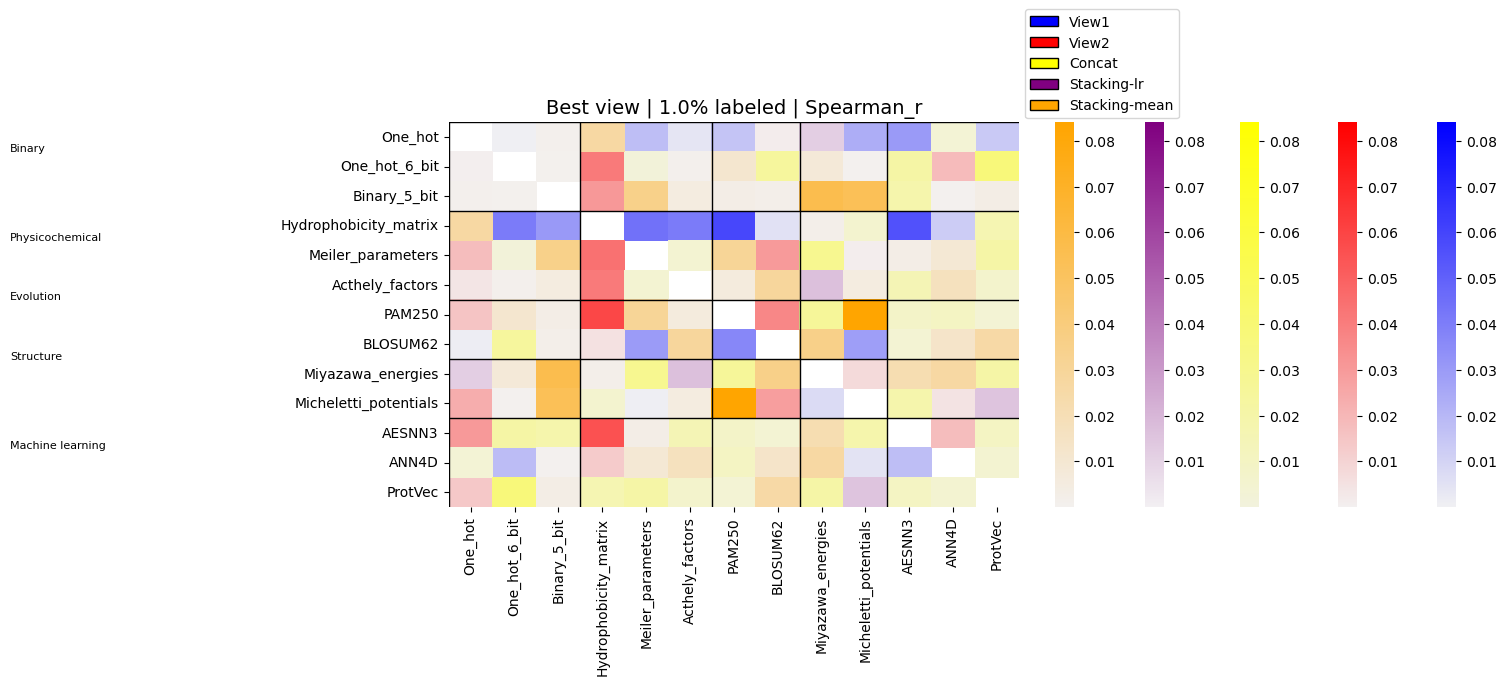

In [31]:
labeled_sizes =  [0.5, 0.25, 0.15, 0.1, 0.05, 0.03, 0.01]
# labeled_sizes =  [0.1]
for labeled_size in labeled_sizes:
    
    views =  ["Concat", "Stacking-lr", "Stacking-mean", "View1", "View2"]
    
    metric = "Spearman_r"   # "MSE", "Spearman_r" or "Spearman_tau"
    one_vs_all_dict = {}
    one_vs_all_dict["View1"] = create_heatmap_dict(get_one_vs_all_results(df, metric, encodings, "View1", views), labeled_size, "View1")
    one_vs_all_dict["View2"] = create_heatmap_dict(get_one_vs_all_results(df, metric, encodings, "View2", views), labeled_size, "View2")
    one_vs_all_dict["Concat"] = create_heatmap_dict(get_one_vs_all_results(df, metric, encodings, "Concat", views), labeled_size, "Concat")
    one_vs_all_dict["Stacking-lr"] = create_heatmap_dict(get_one_vs_all_results(df, metric, encodings, "Stacking-lr", views), labeled_size, "Stacking-lr")
    one_vs_all_dict["Stacking-mean"] = create_heatmap_dict(get_one_vs_all_results(df, metric, encodings, "Stacking-mean", views), labeled_size, "Stacking-mean")
   
    create_heatmap_dict_all_vs_all(one_vs_all_dict, labeled_size, metric)


# Boxplots for a encoding pair

In [12]:
#selected_metric = "AUC"
selected_metric = "Spearman_r"

/tmp/ipykernel_3370453/3650694484.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boxplot_df['Mean_train_size'] = boxplot_df.groupby(['Labeled', 'View'])['Train_size'].transform('mean').round(0).astype(int)
/tmp/ipykernel_3370453/3650694484.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boxplot_df['Labeled_Train_size'] = boxplot_df['Labeled'].astype(str) + '\n\n' + boxplot_df['Mean_train_size'].astype(str)


Text(0.5, 1.0, 'One_hot vs Micheletti_potentials | Spearman_r by view | 5-fold CV')

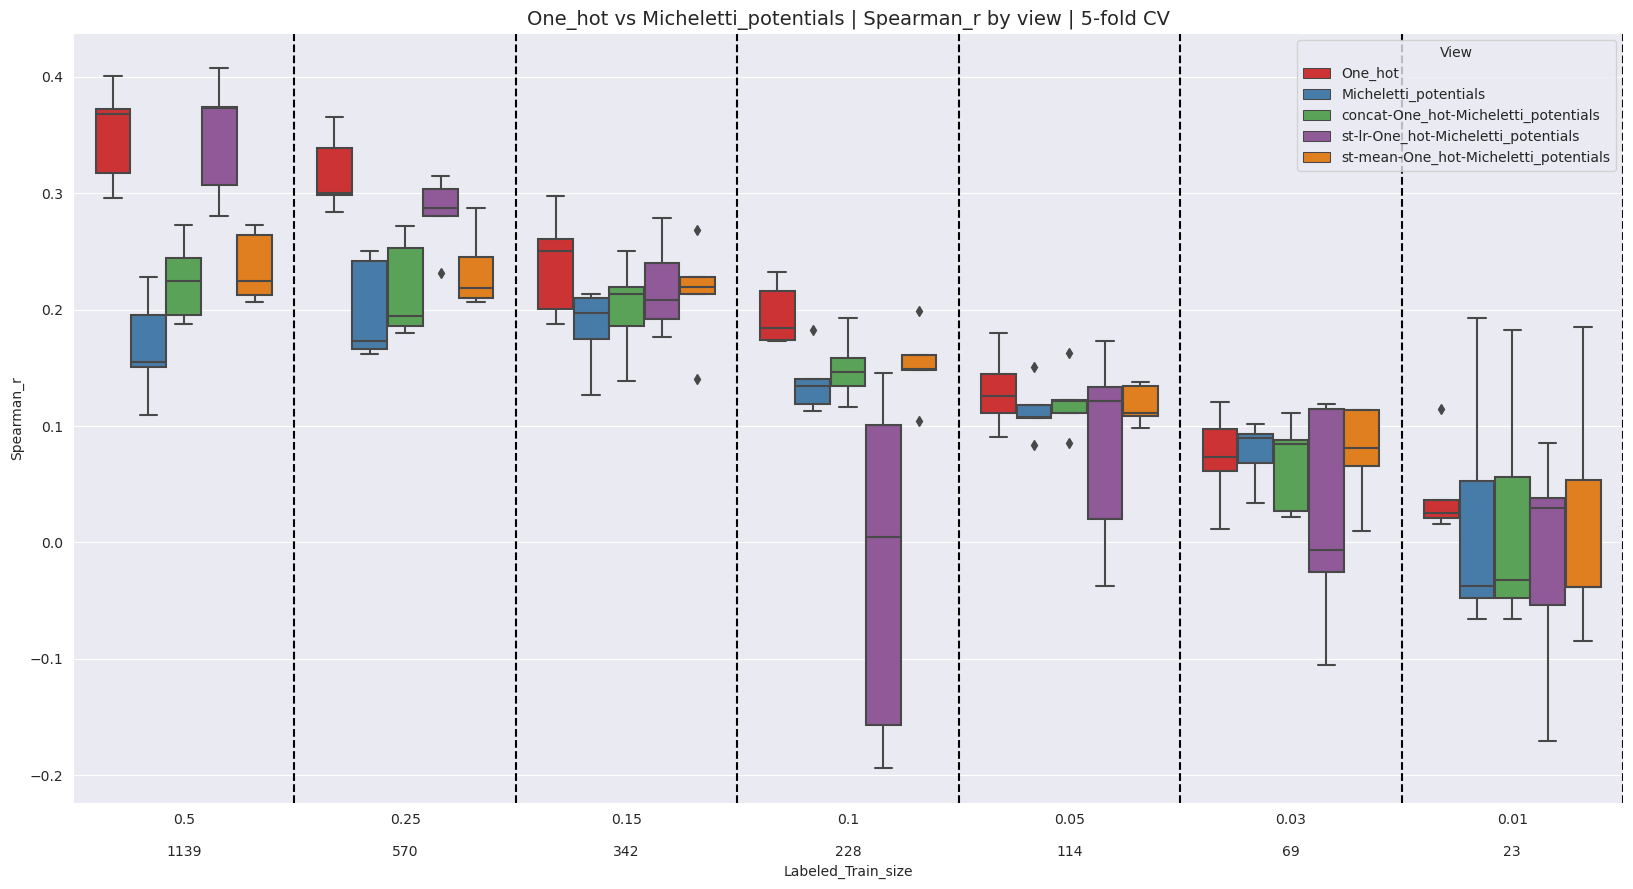

In [13]:
enc1 = 'One_hot'
enc2 = 'Micheletti_potentials'
#for enc1, enc2 in combinations(encodings, 2):
# Boxplot for folds aucs
plt.figure(figsize=(20, 10))

boxplot_df = df.loc[(df['View'] == f"cotraining-{enc1}-{enc2}") | (df['View'] == enc1) | (df['View'] == enc2) | (df['View'] == f"concat-{enc1}-{enc2}") | (df['View'] == f"st-lr-{enc1}-{enc2}") | (df['View'] == f"st-mean-{enc1}-{enc2}")]
boxplot_df['Mean_train_size'] = boxplot_df.groupby(['Labeled', 'View'])['Train_size'].transform('mean').round(0).astype(int)
boxplot_df['Labeled_Train_size'] = boxplot_df['Labeled'].astype(str) + '\n\n' + boxplot_df['Mean_train_size'].astype(str)
# Boxplot grouped by labeled
# Vertical and horizontal grid background
sns.set_style("darkgrid")
# Add underscore at the beginning of every instance in view column in boxplot_df
# pointplot_df = boxplot_df.copy()
# pointplot_df["View"] = pointplot_df['View'].apply(lambda x: f"_{x}")
# ax = sns.pointplot(data=pointplot_df, x='Labeled', y='AUC', 
#                     hue='View', ci=None, linestyles=":",
#                     dodge=.8-0.8/4, scale=0.8, markers="",
#                     palette="Set1")
#plt.setp(ax.lines, zorder=0)
sns.boxplot(x="Labeled_Train_size", y=selected_metric, hue="View", data=boxplot_df, palette="Set1")
[plt.axvline(x+0.5, color = 'black', linestyle='--') for x in range(len(labeled_sizes))]
plt.title(f'{enc1} vs {enc2} | {selected_metric} by view | 5-fold CV', fontsize=14)
#plt.gca().invert_xaxis()

# Ranking of encoding couples for each labeled percentage

In [14]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    # Rank df by AUC mean grouped by view and labeled
    display(df.loc[(df["Labeled"] == 0.10)].groupby(['View', 'Labeled']).mean().sort_values(by=['Labeled', 'AUC'], ascending=False))
    #display(df.groupby(['View', 'Labeled']).mean().sort_values(by=['Labeled', 'AUC'], ascending=False))

KeyError: 'AUC'